In [1]:
library(rgl)
library(wildlifeDI) # Jed's package
library(plyr) # have to use plyr::join because adehabitatMA masks join and ID
library(adehabitatLT) # also required for everything in Jed's package, 
#                     but does not automatically install or load with 
#                     the library command.
#                     it is used to create the trajectory objects

Loading required package: sp
Loading required package: ade4
Loading required package: adehabitatMA

Attaching package: ‘adehabitatMA’

The following object is masked from ‘package:plyr’:

    join

Loading required package: CircStats
Loading required package: MASS
Loading required package: boot

Attaching package: ‘adehabitatLT’

The following object is masked from ‘package:plyr’:

    id



## Data Wrangling!!!
There is significant wrangling, to get the dates (and more! see comments inline) right for both the plot3d function and the wildlifeDI trajectory files

In [2]:
#setwd('~/DATA/BEARS') #have to change this to 
##                    mesh with the github directory structure
bears = read.csv('Data/CopyOfBrown_bear_Slovenia_1993-1999.csv')

#making a number for each bear (plot3d doesn't like characters as far as i can tell)

levels = as.data.frame(levels(bears$individual.local.identifier))
levels$bear_number = c(1:22)
bears$tag = bears$individual.local.identifier
levels$tag = levels$`levels(bears$individual.local.identifier)`
bears = plyr::join(bears, levels, by = "tag")
bears$date = paste(substr(bears$timestamp, 1,4),substr(bears$timestamp,6,7),substr(bears$timestamp,9,10),sep="")
bears$date = as.Date(bears$date, "%Y%m%d")
bears$da = as.POSIXct(strptime(as.character(bears$date), "%Y-%m-%d"))

# stuff's not working for creating trajectory objects, hence (from google)

# sum(duplicated(paste(bears$da, bears$individual.local.identifier)))
# duplicated(paste(bears$da, bears$individual.local.identifier))

# the first line identifies how many duplicates there are, second line 
# helps you manually figure out which one is which, so we can get rid 
# of those rows

bears = bears[-692,]
bears = bears[-1715,]
bears = bears[-154,]
#and then another duplicate magically creates itself
bears = bears[-1713,]

## Plotting 3d
This is bit of an unstable package so far. I haven't found the way to make the plot pop up inside the web page, rather than in a pop up window. Looks cool though! The hardest thing is getting 22 colors that aren't going to confuse you. I suspect the solution lies with RColorBrewer.

For this I first create a 3d plot of the points, and then loop through and create a line for each bear.

In [3]:
cols = colors() #vector of all colors
set.seed(1223)
bear_colors = cols[as.integer(runif(22,1,657))]

plot3d(bears$utm.easting, bears$utm.northing, bears$date, col= bear_colors[bears$bear_number])

for(i in 1:22){
  bear_n = bears[bears$bear_number == i,]
  x = bear_n$utm.easting
  y = bear_n$utm.northing
  z = bear_n$date
  lines3d(x,y,z,col=bear_colors[i])
}

## WildlifeDI
I had some troubles with this. The data formats are really fussy, and for all the really cool tests, I got a lot of mysterious errors that Duck Duck Go had no solution for. However, Duck Duck Go did help me at least get the temporal overlap for all 22 bears against each other.

#### We start by creating trajectory files for each bear

In [4]:
#333333333333333333333333333333333
#
# wildlifeDI stuff
#


# First, create trajectories for each bear

for(i in 1:22){

  bear_n = bears[bears$bear_number == i,]
  xy = bear_n[,14:15]
  da = bear_n$da
  id = as.factor(bear_n$bear_number)
  
  tr1 <- as.ltraj(xy,
                 date = da,
                 id=id)
  nam = paste("tr", i, sep = "_")
  assign(nam, tr1)

}


### The CheckTO function

This function outputs a list of 3 items:
1. True or False: is there temporal overlap?
2. When the overlap starts
3. When the overlap ends

I constructed two loops; first for the occurence of overlap, and the second for the duration of overlap (in days)

In [5]:
# put trajectories into lists
TR_list = list(tr_1,tr_2, tr_3,tr_4, tr_5,tr_6,tr_7,tr_8,tr_9,tr_10, tr_11, tr_12,tr_13, tr_14, tr_15, tr_16, tr_17,tr_18,tr_19,tr_20,tr_21,tr_22)
TR_list1 = TR_list


results_checkTO = as.data.frame(matrix(nrow = 22, ncol = 22))
for(i in 1:22){
  for(j in 1:22){
    
  a = TR_list[[i]]
  b = TR_list1[[j]]
  results_checkTO[i,j]=ifelse(i==j, NA, wildlifeDI::checkTO(a,b))
  }}

results_checkTO_duration = as.data.frame(matrix(nrow = 22, ncol = 22))
for(i in 1:22){
  for(j in 1:22){
    
  a = TR_list[[i]]
  b = TR_list1[[j]]
  results_checkTO_duration[i,j]=ifelse(i==j, NA, checkTO(a,b)[[3]]-checkTO(a,b)[[2]])
  }}



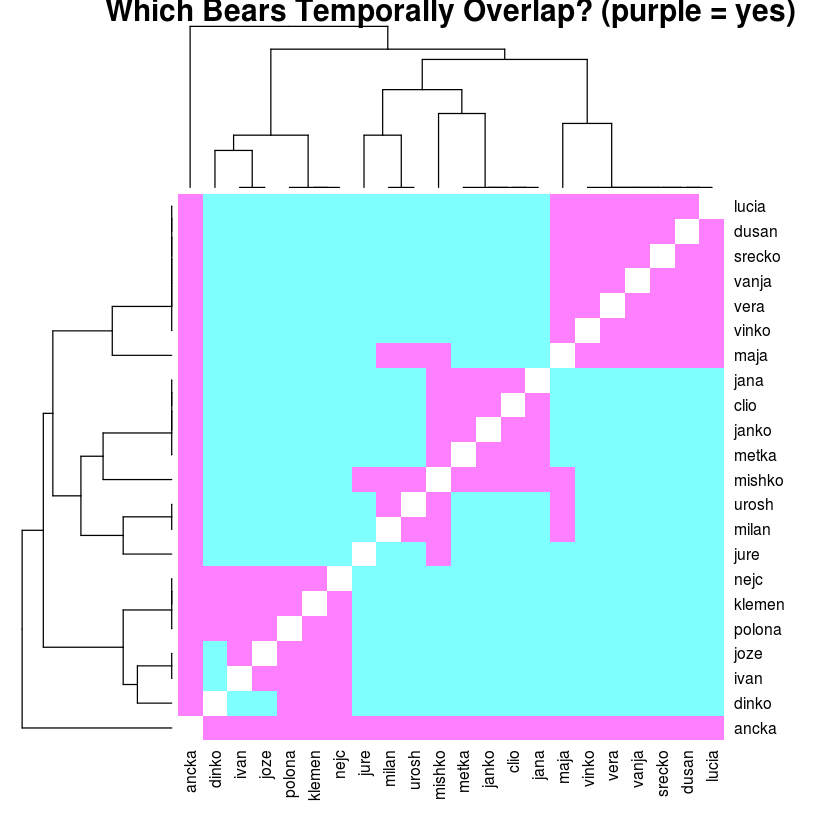

In [12]:
RM = data.matrix(results_checkTO)
rownames(RM) = levels$tag
colnames(RM) = levels$tag
heatmap(RM,  col = cm.colors(256), scale = "none",
          main = "Which Bears Temporally Overlap? (purple = yes)")

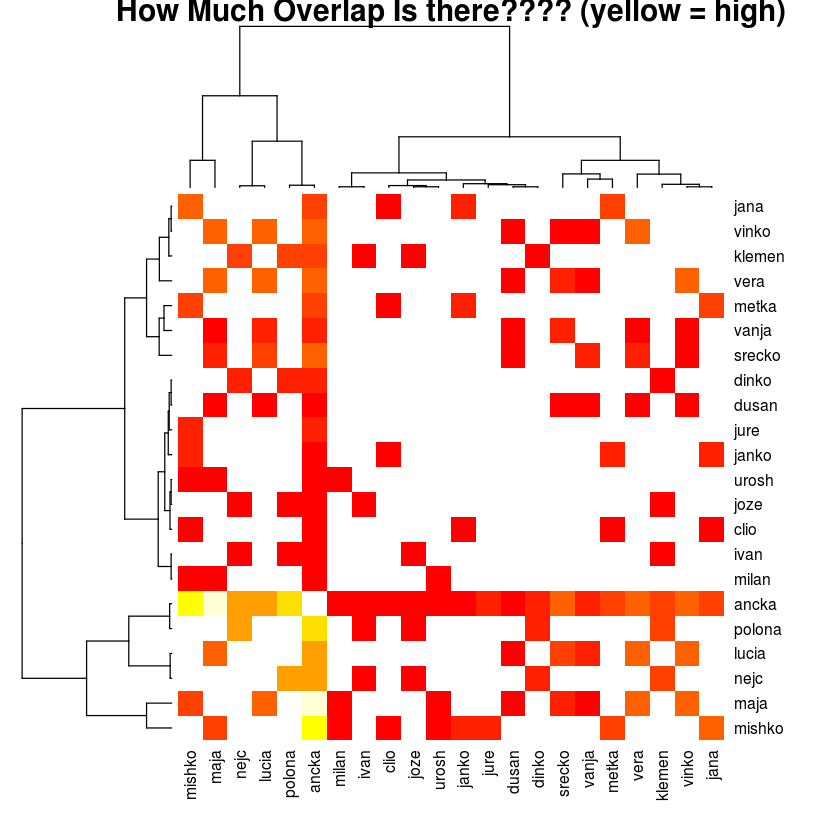

In [14]:
RDM =data.matrix(results_checkTO_duration)
rownames(RDM) = levels$tag
colnames(RDM) = levels$tag
heatmap(RDM, scale="none", main = "How Much Overlap Is there???? (yellow = high)")

In [9]:
RDM

,ancka,clio,dinko,dusan,ivan,jana,janko,joze,jure,klemen,⋯,metka,milan,mishko,nejc,polona,srecko,urosh,vanja,vera,vinko
ancka,NA,36.00000,69.04167,66,12,197.04167,55.00000,44.95833,79,185,⋯,153.00000,9,562.0417,346.00000,520.00000,218.00000,48,113,249.00000,199.95833
clio,36.00000,NA,NA,NA,NA,63.95833,61.95833,NA,NA,NA,⋯,63.95833,NA,52.0000,NA,NA,NA,NA,NA,NA,NA
dinko,69.04167,NA,NA,NA,NA,NA,NA,NA,NA,39,⋯,NA,NA,NA,69.04167,69.04167,NA,NA,NA,NA,NA
dusan,66.00000,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,66.00000,NA,66,38.00000,15.00000
ivan,12.00000,NA,NA,NA,NA,NA,NA,12.00000,NA,12,⋯,NA,NA,NA,12.00000,12.00000,NA,NA,NA,NA,NA
jana,197.04167,63.95833,NA,NA,NA,NA,80.95833,NA,NA,NA,⋯,182.95833,NA,213.0417,NA,NA,NA,NA,NA,NA,NA
janko,55.00000,61.95833,NA,NA,NA,80.95833,NA,NA,NA,NA,⋯,80.95833,NA,71.0000,NA,NA,NA,NA,NA,NA,NA
joze,44.95833,NA,NA,NA,12,NA,NA,NA,NA,25,⋯,NA,NA,NA,39.95833,26.00000,NA,NA,NA,NA,NA
jure,79.00000,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,79.0000,NA,NA,NA,NA,NA,NA,NA
klemen,185.00000,NA,39.00000,NA,12,NA,NA,25.00000,NA,NA,⋯,NA,NA,NA,185.00000,185.00000,NA,NA,NA,NA,NA
